In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import statsmodels.formula.api as smf
from scipy.stats import boxcox, probplot, norm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from QuClu import myfunctions

In [2]:
with pa.memory_map('data/Experiment3_AllFixations_short.arrow', 'r') as source:
    data = pa.ipc.open_file(source).read_all()
    
df = data.to_pandas()
df

,distance_to_spaceship,fixation_duration,Dist_to_closest_obstacles,N_visible_obstacles,input_noise,ID,level,trial,distant_fixation,cluster,disargeement
0,6.532785,0.1470,6.097491,6.0,0.0,AU25IL,1.0,15,1.0,1,1.0
1,6.075962,0.6490,2.892411,5.0,0.0,AU25IL,1.0,15,1.0,1,1.0
2,8.698109,0.5380,3.681632,6.0,0.0,AU25IL,1.0,15,1.0,1,1.0
3,6.840493,0.2160,5.004505,5.0,0.0,AU25IL,1.0,15,1.0,1,1.0
4,6.132214,0.3785,4.208327,6.0,0.0,AU25IL,1.0,15,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
27408,2.140648,0.0455,5.550318,2.0,2.0,IA19EI,6.0,11,0.0,0,1.0
27409,1.782098,0.0445,5.788002,2.0,2.0,IA19EI,6.0,11,0.0,0,1.0
27410,1.654277,0.0290,6.121837,2.0,2.0,IA19EI,6.0,11,0.0,0,1.0
27411,1.579990,0.0030,6.335640,2.0,2.0,IA19EI,6.0,11,0.0,0,1.0


In [3]:
df.columns

Index(['distance_to_spaceship', 'fixation_duration',
       'Dist_to_closest_obstacles', 'N_visible_obstacles', 'input_noise', 'ID',
       'level', 'trial', 'distant_fixation', 'cluster', 'disargeement'],
      dtype='object')

# Principal Component Analysis (PCA)

In [4]:
# features of interest
features = ["distance_to_spaceship", "fixation_duration", "Dist_to_closest_obstacles"]

# seperating features
x = df.loc[:, features].values

# define target
y = df.loc[:,['distant_fixation']].values

# standardize features
x = StandardScaler().fit_transform(x)

In [5]:
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['distance_to_spaceship', 'fixation_duration', 'Dist_to_closest_obstacles'])

In [6]:
finalDf = pd.concat([principalDf, df[['distant_fixation']]], axis = 1)

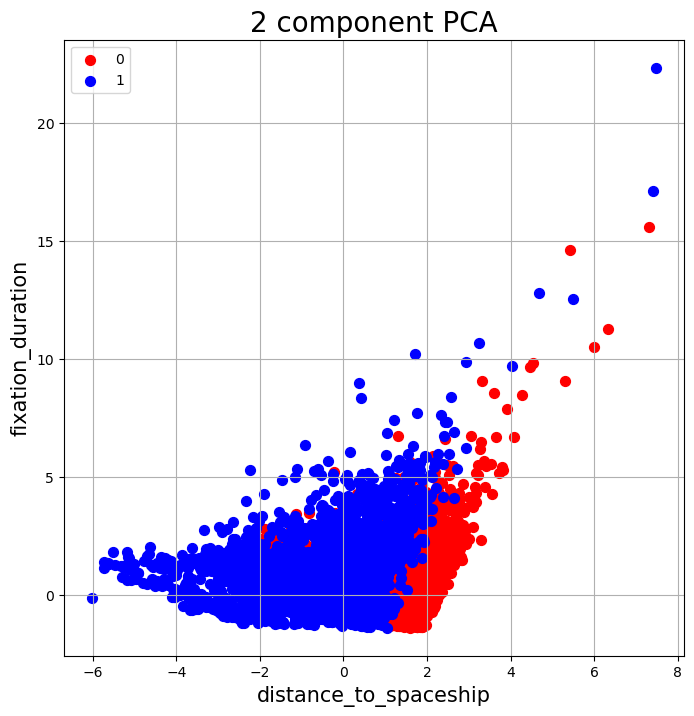

In [7]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('distance_to_spaceship', fontsize = 15)
ax.set_ylabel('fixation_duration', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['distant_fixation'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'distance_to_spaceship']
               , finalDf.loc[indicesToKeep, 'fixation_duration']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [8]:
pca.explained_variance_ratio_

array([0.39923173, 0.3317225 , 0.26904577])

# Quantile-Based Clustering

### Variable-wise theta_j and Scaled variables through lambda_j

Here, we will assess the 'elbow', as well as the silhouette score

In [11]:
dir(myfunctions)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'alg_CS',
 'alg_CU',
 'alg_VS',
 'alg_VU',
 'fun_CS',
 'fun_CU',
 'fun_VS',
 'fun_VU',
 'math',
 'minimize',
 'np',
 'pd']

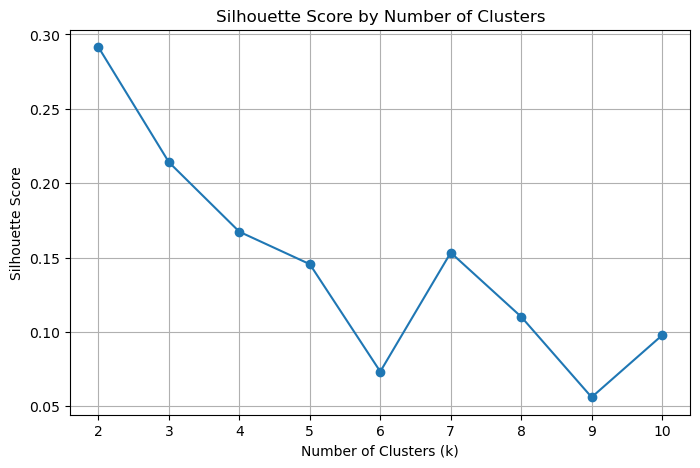

Optimal number of clusters: 2


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = ["distance_to_spaceship", "fixation_duration", "Dist_to_closest_obstacles"]
X = df[features]

# normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# silhouette score
silhouette_scores = []
K_range = range(2, 11)  # 2-10 clusters

for k in K_range:
    #kmeans = KMeans(n_clusters=k, random_state=42)
    #labels = kmeans.fit_predict(X_scaled)
    cluster = myfunctions.alg_VS(X, k=k, B=50)
    labels = cluster['cl']
    
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# plotting
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {optimal_k}")


In [13]:
# assinging Ncluster to data points and save
features = ["distance_to_spaceship", "fixation_duration", "Dist_to_closest_obstacles"]
X = df[features]

cluster = myfunctions.alg_VS(X, k=2, B=50)
labels = cluster['cl']

df['N_qclu'] = labels

In [14]:
#df.to_csv('data/Experiment3_AllFixations_clustered.csv', index=False)

# Clustered Data Analysis 

In [15]:
# trial-level info (one row per ID/trial)
trial_info = (
    df[['ID', 'trial', 'level', 'input_noise']]
    .drop_duplicates()
)

# counting fixations per cluster per trial
fixation_counts = (
    df.groupby(['ID', 'trial', 'N_qclu'])
      .size()
      .reset_index(name='n_fixations')
)

# pivot
fixation_counts_pivot = fixation_counts.pivot(
    index=['ID', 'trial'],
    columns='N_qclu',
    values='n_fixations'
)


fixation_counts_pivot.columns = [f'n_fixations_cluster_{col}' for col in fixation_counts_pivot.columns]
fixation_counts_pivot = fixation_counts_pivot.reset_index()

# merge with trial-level info
merged = pd.merge(trial_info, fixation_counts_pivot, on=['ID', 'trial'])

merged = merged.fillna(0).astype({'n_fixations_cluster_0': 'int', 'n_fixations_cluster_1': 'int'})
print(merged.head())


       ID trial  level  input_noise  n_fixations_cluster_0  \
0  AU25IL    15    1.0          0.0                     23   
1  AU25IL    31    1.0          0.5                     41   
2  AU25IL    44    1.0          1.0                     77   
3  AU25IL    34    1.0          1.5                     51   
4  AU25IL    27    1.0          2.0                      6   

   n_fixations_cluster_1  
0                     12  
1                     21  
2                     22  
3                     28  
4                      4  


### Visual inspection

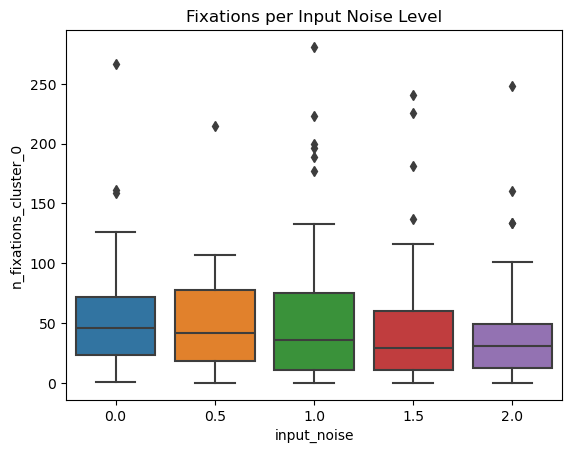

In [16]:
# visual inspection
sns.boxplot(data=merged, x='input_noise', y='n_fixations_cluster_0')
plt.title("Fixations per Input Noise Level")
plt.show()

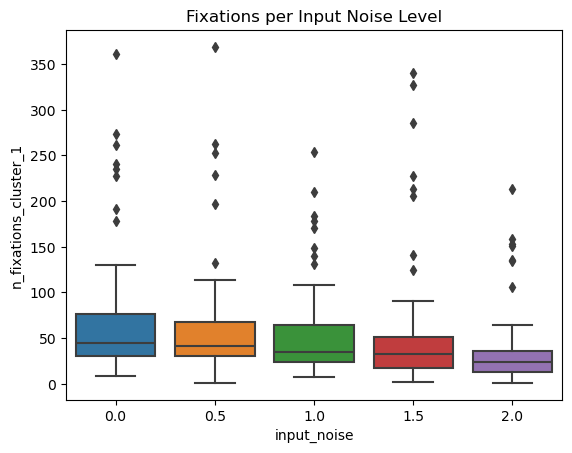

In [17]:
sns.boxplot(data=merged, x='input_noise', y='n_fixations_cluster_1')
plt.title("Fixations per Input Noise Level")
plt.show()

## Linear mixed effects modeling

### N fixations

In [18]:
model = smf.mixedlm(
    "n_fixations_cluster_0 ~ input_noise",
    data=merged,
    groups=merged["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:            MixedLM Dependent Variable: n_fixations_cluster_0
No. Observations: 254     Method:             ML                   
No. Groups:       6       Scale:              1554.7577            
Min. group size:  35      Log-Likelihood:     -1304.0370           
Max. group size:  48      Converged:          Yes                  
Mean group size:  42.3                                             
---------------------------------------------------------------------
               Coef.     Std.Err.     z      P>|z|    [0.025   0.975]
---------------------------------------------------------------------
Intercept       59.513     14.358    4.145   0.000    31.373   87.654
input_noise     -8.746      3.444   -2.539   0.011   -15.497   -1.996
Group Var     1105.971     16.974                                    
===================================================================

"""

In [19]:
model = smf.mixedlm(
    "n_fixations_cluster_1 ~ input_noise",
    data=merged,
    groups=merged["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
===================================================================
Model:            MixedLM Dependent Variable: n_fixations_cluster_1
No. Observations: 254     Method:             ML                   
No. Groups:       6       Scale:              2777.0886            
Min. group size:  35      Log-Likelihood:     -1377.6847           
Max. group size:  48      Converged:          Yes                  
Mean group size:  42.3                                             
--------------------------------------------------------------------
                  Coef.    Std.Err.    z     P>|z|   [0.025   0.975]
--------------------------------------------------------------------
Intercept          83.518    19.122   4.368  0.000   46.040  120.996
input_noise       -20.301     4.603  -4.410  0.000  -29.322  -11.279
Group Var        1959.988    22.474                                 
===================================================================

"""

## Analyze fixation metrics

In [20]:
df.columns

Index(['distance_to_spaceship', 'fixation_duration',
       'Dist_to_closest_obstacles', 'N_visible_obstacles', 'input_noise', 'ID',
       'level', 'trial', 'distant_fixation', 'cluster', 'disargeement',
       'N_qclu'],
      dtype='object')

In [21]:
type_0 = df[df.N_qclu == 0]
type_1 = df[df.N_qclu == 1]

### Distance to Spaceship

In [22]:
_, lmbda = boxcox(type_0.distance_to_spaceship)
lmbda

0.5406988301130733

In [23]:
type_0['distance_to_spaceship_t'] = np.sqrt(type_0.distance_to_spaceship)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1706/1701825223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_0['distance_to_spaceship_t'] = np.sqrt(type_0.distance_to_spaceship)


In [24]:
model = smf.mixedlm(
    "distance_to_spaceship_t ~ input_noise",
    data=type_0,
    groups=type_0["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:            MixedLM Dependent Variable: distance_to_spaceship_t
No. Observations: 12648   Method:             ML                     
No. Groups:       6       Scale:              0.2131                 
Min. group size:  204     Log-Likelihood:     -8186.9219             
Max. group size:  4660    Converged:          Yes                    
Mean group size:  2108.0                                             
------------------------------------------------------------------------
               Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
------------------------------------------------------------------------
Intercept       1.568       0.088    17.863    0.000     1.396     1.740
input_noise    -0.021       0.006    -3.677    0.000    -0.033    -0.010
Group Var       0.046       0.058                                       
=====================================================================

"""

In [25]:
_, lmbda = boxcox(type_1.distance_to_spaceship)
lmbda

-0.8998088878601408

In [26]:
type_1['distance_to_spaceship_t'] = 1/type_1.distance_to_spaceship

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1706/1722555321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_1['distance_to_spaceship_t'] = 1/type_1.distance_to_spaceship


In [27]:
model = smf.mixedlm(
    "distance_to_spaceship_t ~ input_noise",
    data=type_1,
    groups=type_1["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:            MixedLM Dependent Variable: distance_to_spaceship_t
No. Observations: 14765   Method:             ML                     
No. Groups:       6       Scale:              0.0009                 
Min. group size:  891     Log-Likelihood:     31069.8229             
Max. group size:  5748    Converged:          Yes                    
Mean group size:  2460.8                                             
------------------------------------------------------------------------
               Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
------------------------------------------------------------------------
Intercept       0.131       0.003    43.179    0.000     0.125     0.137
input_noise    -0.000       0.000    -1.280    0.200    -0.001     0.000
Group Var       0.000       0.001                                       
=====================================================================

"""

### Fixation duration

In [28]:
_, lmbda = boxcox(type_0.fixation_duration)
lmbda

0.0940700507227688

In [29]:
type_0['fixation_duration_t'] = np.log(type_0.fixation_duration)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1706/331492430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_0['fixation_duration_t'] = np.log(type_0.fixation_duration)


In [30]:
model = smf.mixedlm(
    "fixation_duration_t ~ input_noise",
    data=type_0,
    groups=type_0["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:            MixedLM Dependent Variable: fixation_duration_t
No. Observations: 12648   Method:             ML                 
No. Groups:       6       Scale:              1.9950             
Min. group size:  204     Log-Likelihood:     -22336.5143        
Max. group size:  4660    Converged:          Yes                
Mean group size:  2108.0                                         
-------------------------------------------------------------------
               Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-------------------------------------------------------------------
Intercept      -2.072      0.604   -3.429   0.001   -3.256   -0.888
input_noise    -0.094      0.018   -5.326   0.000   -0.129   -0.060
Group Var       2.185      0.888                                   
=================================================================

"""

In [31]:
_, lmbda = boxcox(type_1.fixation_duration)
lmbda

-0.016656559488899835

In [32]:
type_1['fixation_duration_t'] = np.log(type_1.fixation_duration)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1706/3574830597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_1['fixation_duration_t'] = np.log(type_1.fixation_duration)


In [33]:
model = smf.mixedlm(
    "fixation_duration_t ~ input_noise",
    data=type_1,
    groups=type_1["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:            MixedLM Dependent Variable: fixation_duration_t
No. Observations: 14765   Method:             ML                 
No. Groups:       6       Scale:              1.9571             
Min. group size:  891     Log-Likelihood:     -25930.6529        
Max. group size:  5748    Converged:          Yes                
Mean group size:  2460.8                                         
-------------------------------------------------------------------
               Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-------------------------------------------------------------------
Intercept      -2.448      0.584   -4.193   0.000   -3.593   -1.304
input_noise     0.039      0.016    2.411   0.016    0.007    0.071
Group Var       2.043      0.842                                   
=================================================================

"""

### Distance to closest obstacle

In [34]:
_, lmbda = boxcox(type_0.Dist_to_closest_obstacles)
lmbda

0.16203584042677063

In [35]:
type_0['Dist_to_closest_obstacles_t'] = np.log(type_0.Dist_to_closest_obstacles)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1706/642020871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_0['Dist_to_closest_obstacles_t'] = np.log(type_0.Dist_to_closest_obstacles)


In [36]:
model = smf.mixedlm(
    "Dist_to_closest_obstacles_t ~ input_noise",
    data=type_0,
    groups=type_0["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:            MixedLM Dependent Variable: Dist_to_closest_obstacles_t
No. Observations: 12648   Method:             ML                         
No. Groups:       6       Scale:              0.3119                     
Min. group size:  204     Log-Likelihood:     -10590.7906                
Max. group size:  4660    Converged:          Yes                        
Mean group size:  2108.0                                                 
----------------------------------------------------------------------------
                   Coef.     Std.Err.      z       P>|z|    [0.025    0.975]
----------------------------------------------------------------------------
Intercept           1.037       0.041    25.306    0.000     0.957     1.117
input_noise        -0.001       0.007    -0.130    0.897    -0.015     0.013
Group Var           0.009       0.010                                       
=========================================================================

"""

In [37]:
_, lmbda = boxcox(type_1.Dist_to_closest_obstacles)
lmbda

0.24737817865656006

In [38]:
type_1['Dist_to_closest_obstacles_t'] = np.log(type_1.Dist_to_closest_obstacles)

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1706/2089663632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_1['Dist_to_closest_obstacles_t'] = np.log(type_1.Dist_to_closest_obstacles)


In [39]:
model = smf.mixedlm(
    "Dist_to_closest_obstacles_t ~ input_noise",
    data=type_1,
    groups=type_1["ID"]
)
model_fit = model.fit(reml=False)

model_fit.summary()

/Users/heinrich/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:            MixedLM Dependent Variable: Dist_to_closest_obstacles_t
No. Observations: 14765   Method:             ML                         
No. Groups:       6       Scale:              0.2060                     
Min. group size:  891     Log-Likelihood:     -9298.4565                 
Max. group size:  5748    Converged:          Yes                        
Mean group size:  2460.8                                                 
-----------------------------------------------------------------------------
                Coef.     Std.Err.       z        P>|z|     [0.025     0.975]
-----------------------------------------------------------------------------
Intercept       1.324        0.029     46.278     0.000      1.268      1.380
input_noise     0.034        0.005      6.501     0.000      0.024      0.045
Group Var       0.005        0.006                                           
=========================================================================

"""